In [1]:
from diffusers import DiffusionPipeline
import torch

/home/gaurav/anaconda3/envs/base_flash_attn/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Some Notes about diffusion models.

Denoising Diffusion Probabilistic Models (DDPM) is based on the principle that a model can correct itself over a small number of steps and gradually produce a good sample. The neural network is trained to predict the noise added to the image at each step.

https://theaisummer.com/diffusion-models/?fbclid=IwAR1BIeNHqa3NtC8SL0sKXHATHklJYphNH-8IGNoO3xZhSKM_GYcvrrQgB0o

In [2]:
pipeline = DiffusionPipeline.from_pretrained(
    "stable-diffusion-v1-5/stable-diffusion-v1-5", torch_dtype=torch.float16).to("cuda")

prompt = "An image of a squirrel in Picasso style"
print(f"Pipeline {pipeline}")
image = pipeline(prompt).images[0]

image.show()

Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00,  7.03it/s]


Pipeline StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.32.2",
  "_name_or_path": "stable-diffusion-v1-5/stable-diffusion-v1-5",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}



100%|██████████| 50/50 [00:03<00:00, 14.37it/s]


/tmp/ipykernel_1208165/3456372803.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0.2)  # Reduce spacing further


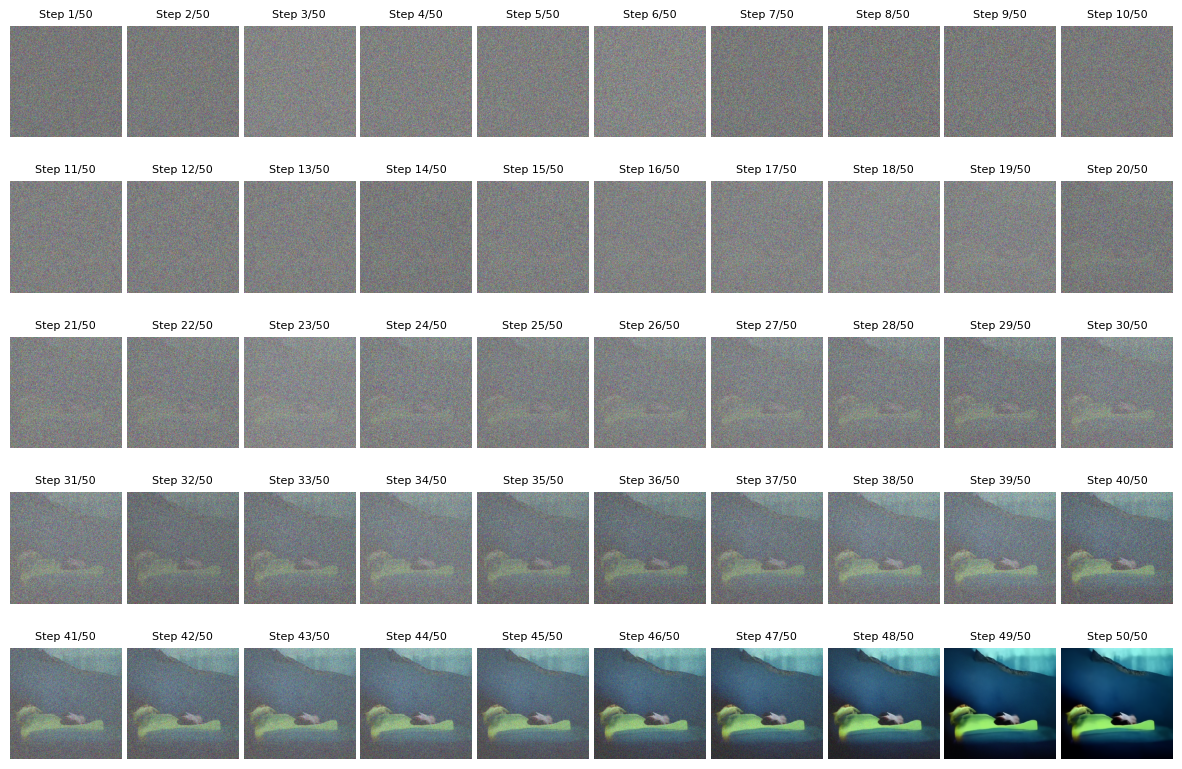

In [14]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from diffusers import DDPMScheduler, UNet2DModel

# Load scheduler and model
scheduler = DDPMScheduler.from_pretrained("google/ddpm-cat-256")
model = UNet2DModel.from_pretrained("google/ddpm-cat-256").to("cuda")
scheduler.set_timesteps(50)

# Generate initial noise
sample_size = model.config.sample_size
input = torch.randn((1, 3, sample_size, sample_size), device=model.device, dtype=model.dtype)

# Store images at each step
images = []
step_numbers = []

for i, t in enumerate(scheduler.timesteps):
    with torch.no_grad():
        noisy_residual = model(input, t).sample
        prev_noisy_sample = scheduler.step(noisy_residual, t, input).prev_sample
        input = prev_noisy_sample
        
        # Convert to PIL Image and store
        img = input.squeeze().detach().cpu().permute(1, 2, 0).numpy()
        img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0, 1]
        img = (img * 255).astype(np.uint8)  # Convert to uint8
        images.append(img)
        step_numbers.append(f"Step {i+1}/{len(scheduler.timesteps)}")

# Plot images in a grid
num_rows = 5  # Number of rows
num_cols = len(images) // num_rows  # Adjust for total images
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10), gridspec_kw={'wspace': 0.05, 'hspace': 0.05})

for idx, ax in enumerate(axes.flat):
    ax.imshow(images[idx])
    ax.set_title(step_numbers[idx], fontsize=8)  # Add step number
    ax.axis("off")

plt.tight_layout(pad=0.2)  # Reduce spacing further
plt.show()

### Classifier-free guidance

Instead of training two models, one conditional and one unconditional, we can train a single model that can take in both the prompt and a noising schedule. And the prompt is given say only 50% of the time.

We can then use both the conditional and unconditional outputs to guide the model depending on how much we want the model to pay attention to the conditioning signal.

$w \cdot (output_{conditioned} - output_{unconditioned}) + output_{unconditioned}$


-------------------------------------------------------------

Where is CLIP (Contrastive Language-Image Pre-Training) used?

Gave the model a text embedding of the prompt and the input image. So, an image and the descrption of the image are given as input to the model.